 ## Setting up a network model and starting a first training

In this and the following exercise, we are going to practise, how to set up a neural network model and perform a first training with this network.
We will use the DermaMNIST from the MedMNIST datasets, which you have seen last lecture.

In [47]:
# Imports
import os
import sys
# from tqdm import trange
# from tqdm import tqdm
# from skimage.util import montage
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision as torchvision

!pip install medmnist
import medmnist
from medmnist.dataset import PathMNIST, ChestMNIST, DermaMNIST, OCTMNIST, PneumoniaMNIST, RetinaMNIST, BreastMNIST, OrganMNISTAxial, OrganMNISTCoronal, OrganMNISTSagittal
from medmnist.evaluator import getAUC, getACC
from medmnist.info import INFO

In [48]:
print("Version:", medmnist.__version__)

Version: 2.0.2


In [49]:
# various MedMNIST datasets
data_flag = 'dermamnist'
download = True
input_root = 'tmp_data/'
!mkdir 'tmp_data'

flag_to_class = {
    "pathmnist": PathMNIST,
    "chestmnist": ChestMNIST,
    "dermamnist": DermaMNIST,
    "octmnist": OCTMNIST,
    "pneumoniamnist": PneumoniaMNIST,
    "retinamnist": RetinaMNIST,
    "breastmnist": BreastMNIST,
    "organmnist_axial": OrganMNISTAxial,
    "organmnist_coronal": OrganMNISTCoronal,
    "organmnist_sagittal": OrganMNISTSagittal,
}

DataClass = flag_to_class[data_flag]

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
label_dict = info['label']

print(f"Info:\n{info}\n")
print(f"Task:\n{task}\n")
print(f"Channels:\n{n_channels}\n")
print(f"Number of classes:\n{n_classes}\n")
print(f"Label:\n{label_dict}\n")

mkdir: tmp_data: File exists
Info:
{'python_class': 'DermaMNIST', 'description': 'The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.', 'url': 'https://zenodo.org/record/5208230/files/dermamnist.npz?download=1', 'MD5': '0744692d530f8e62ec473284d019b0c7', 'task': 'multi-class', 'label': {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}, 'n_channels': 3, 'n_samples': {'train': 7007, 'val': 1003, 'test': 2005}, 'license': 'CC BY-NC 4.0'}

Task:
multi-class

Channels:
3

Number o

## Defining the augmentations

As described in the last exercise, we now define the augmentations:

In [50]:
# Imagenet values
norm_mean = (0.4914)
norm_std = (0.2023)

# define the transformaitons the images go through each time it is used for training
# includes augmentation AND normalization as described above
augmentation_train = transforms.Compose([
                                  # resize image to the network input size
                                  transforms.Resize((28,28)),
                                  # rotate the image with a certain angle range, randomly chosen
                                  transforms.RandomRotation(degrees=20),
                                  # convert the image into a tensor so it can be processed by the GPU
                                  transforms.ToTensor(),
                                  # normalize the image with the mean and std of ImageNet
                                  transforms.Normalize(norm_mean, norm_std),
                                   ])

# no augmentation for the test data only resizing, conversion to tensor and normalization
augmentation_test = transforms.Compose([
                    transforms.Resize((28,28)),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

## Splitting up data

Set up datasets for training, validation and testing

In [51]:
# load the data
train_dataset = DataClass(root=input_root, split='train', transform=augmentation_train, download=download)
test_dataset = DataClass(root=input_root, split='test', transform=augmentation_test, download=download)
val_dataset = DataClass(root=input_root, split='val', transform=augmentation_test, download=download)

19725312it [00:17, 1108541.50it/s]                              


Using downloaded and verified file: tmp_data/dermamnist.npz
Using downloaded and verified file: tmp_data/dermamnist.npz


In [52]:
# Some detailed information about all splits
print("===================")
print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)

Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: tmp_data/
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0
Dataset DermaMNIST (dermamnist)
    Number of datapoints: 1003
    Root location: tmp_dat

## Create Dataloaders

PyTorch provides template Dataloader classes for easy data handling, assigning according transforms and splits. You can find more information about how PyTorch handles datasets and data loading [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [53]:
BATCH_SIZE = 128
### encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [54]:
### the next() function returns the next item from the iterator.
batch_images, batch_labels = next(iter(train_loader))

torch.Size([3, 28, 28])


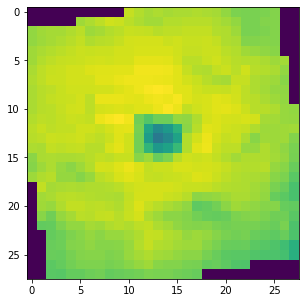

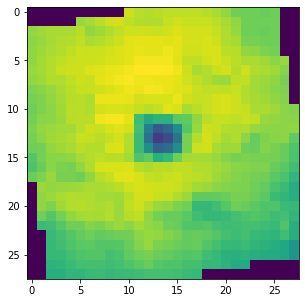

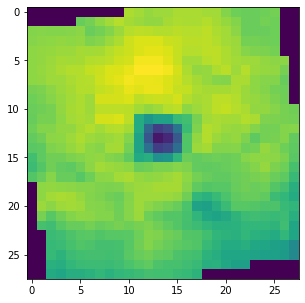

In [55]:
# show all 3 channels of image 10
print(batch_images[0].shape)

fig = plt.figure(figsize=(5, 5))
plt.imshow(batch_images[11][0,:,:])
fig = plt.figure(figsize=(5, 5))
plt.imshow(batch_images[11][1,:,:])
fig = plt.figure(figsize=(5, 5))
plt.imshow(batch_images[11][2,:,:])

### different color maps
### cmap='bone', cmap = 'summer', cmap = 'seismic'

## Define a Convolutional Neural Network

Pytorch makes it very easy to define a neural network. We have layers like Convolutions, ReLU non-linearity, Maxpooling etc. directly from [torch library](https://pytorch.org/docs/stable/nn.html).

In this tutorial, we use The LeNet architecture introduced by LeCun et al. in their 1998 paper, [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). As the name of the paper suggests, the authors’ implementation of LeNet was used primarily for OCR and character recognition in documents. The LeNet architecture is straightforward and small, (in terms of memory footprint), making it perfect for teaching the basics of CNNs.

To define a neural network in PyTorch one has to create a class inhereting from [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Crucially, this class has to include the function forward() which defines which computation should be performed at every call given a batch of inputs.

In [56]:
from torch import nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_classes = len(classes)
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5), padding=2)
        self.nonlin1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5)) 
        self.nonlin2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.fc1 = nn.Linear(in_features=16*5*5, out_features=120)
        self.nonlin3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.nonlin4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=num_classes)
        self.nonlin5 = nn.ReLU()

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.nonlin1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.nonlin2(x)
        x = self.pool2(x)
        
        x = x.view(-1, self.num_flat_features(x))

        x = self.fc1(x)
        x = self.nonlin3(x)
        x = self.fc2(x)
        x = self.nonlin4(x)
        x = self.fc3(x)
        x = self.nonlin5(x)

        return x

    def num_flat_features(self, x):
        
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


You can use torchsummary to print out the architecture of your model given a certain input.

In [57]:
from torchsummary import summary
summary(LeNet(), input_size=(1,28,28), batch_size=BATCH_SIZE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [128, 6, 28, 28]             156
              ReLU-2           [128, 6, 28, 28]               0
         MaxPool2d-3           [128, 6, 14, 14]               0
            Conv2d-4          [128, 16, 10, 10]           2,416
              ReLU-5          [128, 16, 10, 10]               0
         MaxPool2d-6            [128, 16, 5, 5]               0
            Linear-7                 [128, 120]          48,120
              ReLU-8                 [128, 120]               0
            Linear-9                  [128, 84]          10,164
             ReLU-10                  [128, 84]               0
           Linear-11                   [128, 7]             595
             ReLU-12                   [128, 7]               0
Total params: 61,451
Trainable params: 61,451
Non-trainable params: 0
---------------------------------

## Homework

Create a neural network capable of processing the image tensor 'img', which has only one channel. The network should contain at least one convolutional layer and one additional fully connected layer. Pay attention that within the fully connected layer the output dimension of the last convolutional layer has to fit the input dimension. Additionally, the output dimension of the fully connected layer before 'fc_fin' has to match the required input dimension of 'fc_fin'.

Some hints:

- Have a look at how LeNet is implemented above. Many concepts can be copied.
- Focus on using the PyTorch's Linear, Conv2d, MaxPool2d and ReLU layers and the .view() function. You can find detailed information on these components in [PyTorch's documentation](https://pytorch.org/docs/stable/index.html).
- Batch size does not have to be considered when designing the neural networks. PyTorch adapts the calculations automatically when provided with different batch sizes.

In [58]:
img = torch.rand((1, 1, 200, 200))

output_dim = 6

class LeNet2(nn.Module):
    def __init__(self):
        super(LeNet2, self).__init__()

        # --------------------

        ########## Insert your layers here ##########

        # --------------------

        self.fc_fin = nn.Linear(in_features=48, out_features=output_dim)

    def forward(self, x):
        
        # --------------------

        ########## Insert your forward pass here ##########

        # --------------------

        x = self.fc_fin(x)
        
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

model = LeNet2()

output = model(img)

if output.size(1) == 6:
    print('The correct output size has been generated.')
else:
    print('The generated output size is not correct')

RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x200 and 48x6)